# Disaster Tweet Detector (NLP): Preprocessing and Modeling

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.under_sampling import RandomUnderSampler

## Importing Data

In [2]:
tweets_c = pd.read_csv('C:/Users/justi/SpringboardDS/Capstone III/data/cleaned_tweets.csv')
tweets_c.head()

,Unnamed: 0,id,keyword,location,text,target,text_cleaned
0,0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1,communal violence bhainsa telangana stones pel...
1,1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1,telangana section imposed bhainsa january clas...
2,2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1,arsonist sets cars ablaze dealership
3,3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1,arsonist sets cars ablaze dealership
4,4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0,lord jesus love brings freedom pardon fill hol...


In [3]:
# Drop unwanted columns.
tweets_c = tweets_c.drop(columns = ['Unnamed: 0', 'id', 'keyword', 'location', 'text'])
tweets_c.head()

,target,text_cleaned
0,1,communal violence bhainsa telangana stones pel...
1,1,telangana section imposed bhainsa january clas...
2,1,arsonist sets cars ablaze dealership
3,1,arsonist sets cars ablaze dealership
4,0,lord jesus love brings freedom pardon fill hol...


## Preprocessing

In [4]:
# There appears to be one null row still in our dataframe.
tweets_c[tweets_c.isnull().any(axis=1)]

,target,text_cleaned
1500,0,NaN


In [5]:
# Let's drop it.
tweets_c = tweets_c.dropna()

In [6]:
# Split our data into train/test sets.
X = tweets_c.text_cleaned
y = tweets_c.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [7]:
# Build BOW features on trained tweets.
cv = CountVectorizer(binary=False, min_df=5, max_df=1.0, ngram_range=(1,2)) # ignore terms that appear in <5 docs and >100% docs (don't ignore any terms for the max_df setting), includes unigrams and bigrams.
cv_train_features = cv.fit_transform(X_train)

In [8]:
# Build TFIDF features on trained tweets.
tv = TfidfVectorizer(use_idf=True, min_df=5, max_df=1.0, ngram_range=(1,2), sublinear_tf=True)
tv_train_features = tv.fit_transform(X_train)

In [9]:
# Transform test tweets into features.
cv_test_features = cv.transform(X_test)
tv_test_features = tv.transform(X_test)

In [10]:
# Check our vectorized features shape.
print('BOW model:> Train features shape:', cv_train_features.shape, ' Test features shape:', cv_test_features.shape) # Is the 3647 the amount of words in our docs with each column containing counts per tweet?
print('TFIDF model:> Train features shape:', tv_train_features.shape, ' Test features shape:', tv_test_features.shape)

BOW model:> Train features shape: (9095, 3647)  Test features shape: (2274, 3647)
TFIDF model:> Train features shape: (9095, 3647)  Test features shape: (2274, 3647)


## Modeling with Imbalanced Data

### Logistic Regression

In [11]:
# Let's try a Logistic Regression model first using our count vectorized data.
# Initiate the model.
LR_ib_cv = LogisticRegression(penalty='l2', max_iter=500, C=1, solver='lbfgs', random_state=42) # Should I do a gridsearch with text data?

# Fit LR model with our training data.
LR_ib_cv.fit(cv_train_features, y_train)

# Make predictions using our vectorized test features.
LR_ib_bow_predictions = LR_ib_cv.predict(cv_test_features)

In [12]:
# Model evaluation.
labels = ['Not Disaster', 'Disaster']
print(classification_report(y_test, LR_ib_bow_predictions))
pd.DataFrame(confusion_matrix(y_test, LR_ib_bow_predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1867
           1       0.78      0.54      0.64       407

    accuracy                           0.89      2274
   macro avg       0.84      0.75      0.79      2274
weighted avg       0.88      0.89      0.88      2274



,Not Disaster,Disaster
Not Disaster,1805,62
Disaster,188,219


Since we care more about labeling disaster tweets correctly (we want our model to identify disaster tweets correctly more than having high precision within the positive class) we will use recall for the positive (disaster) class as our evaluation metric. Our positive class has a recall of 0.54 which is not great. Let's see how a logistic regression model performs on our TFIDF vectorized data.

In [13]:
# Let's try a Logistic Regression model using our tfidf vectorized data.
# Initiate the model.
LR_ib_tv = LogisticRegression(penalty='l2', max_iter=500, C=1, solver='lbfgs', random_state=42)

# Fit LR model with our training data.
LR_ib_tv.fit(tv_train_features, y_train)

# Make predictions using our vectorized test features.
LR_ib_tfidf_predictions = LR_ib_tv.predict(tv_test_features)

In [14]:
# Model evaluation.
print(classification_report(y_test, LR_ib_tfidf_predictions))
pd.DataFrame(confusion_matrix(y_test, LR_ib_tfidf_predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.88      0.99      0.93      1867
           1       0.87      0.36      0.51       407

    accuracy                           0.88      2274
   macro avg       0.88      0.67      0.72      2274
weighted avg       0.88      0.88      0.85      2274



,Not Disaster,Disaster
Not Disaster,1846,21
Disaster,261,146


The recall here is much worse at 0.36. Let's try a random forest model on both the count and tfidf vectorized data.

### Random Forest

In [15]:
# Let's now try a Random Forest model using our count vectorized data.
# Initiate the model.
RF_ib_cv = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)

# Fit RF model with our training data.
RF_ib_cv.fit(cv_train_features, y_train)

# Make predictions using our vectorized test features.
RF_ib_bow_predictions = RF_ib_cv.predict(cv_test_features)

In [16]:
# Model evaluation.
print(classification_report(y_test, RF_ib_bow_predictions))
pd.DataFrame(confusion_matrix(y_test, RF_ib_bow_predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.90      0.96      0.93      1867
           1       0.74      0.49      0.59       407

    accuracy                           0.88      2274
   macro avg       0.82      0.73      0.76      2274
weighted avg       0.87      0.88      0.87      2274



,Not Disaster,Disaster
Not Disaster,1795,72
Disaster,207,200


In [17]:
# Let's try a Random Forest model using our tfidf vectorized data.
# Initiate the model.
RF_ib_tv = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)

# Fit RF model with our training data.
RF_ib_tv.fit(tv_train_features, y_train)

# Make predictions using our vectorized test features.
RF_ib_tfidf_predictions = RF_ib_tv.predict(tv_test_features)

In [18]:
# Model evaluation.
print(classification_report(y_test, RF_ib_tfidf_predictions))
pd.DataFrame(confusion_matrix(y_test, RF_ib_tfidf_predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      1867
           1       0.80      0.49      0.61       407

    accuracy                           0.89      2274
   macro avg       0.85      0.73      0.77      2274
weighted avg       0.88      0.89      0.87      2274



,Not Disaster,Disaster
Not Disaster,1818,49
Disaster,209,198


So far none of our models are performing at the level that we would like. Our best model is the logistic regression one using the count vectorized data. This model only had a recall of 0.54 for the positive (disaster) class.

### KNN

In [19]:
# Let's now try a KNN model using our count vectorized data.
# Initiate the model.
KNN_ib_cv = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)

# Fit KNN model with our training data.
KNN_ib_cv.fit(cv_train_features, y_train)

# Make predictions using our vectorized test features.
KNN_ib_bow_predictions = KNN_ib_cv.predict(cv_test_features)

In [20]:
# Model evaluation.
print(classification_report(y_test, KNN_ib_bow_predictions))
pd.DataFrame(confusion_matrix(y_test, KNN_ib_bow_predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.85      0.99      0.91      1867
           1       0.82      0.20      0.32       407

    accuracy                           0.85      2274
   macro avg       0.84      0.59      0.62      2274
weighted avg       0.85      0.85      0.81      2274



,Not Disaster,Disaster
Not Disaster,1850,17
Disaster,327,80


In [21]:
# Let's now try a KNN model using our tfidf vectorized data.
# Initiate the model.
KNN_ib_tv = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)

# Fit KNN model with our training data.
KNN_ib_tv.fit(tv_train_features, y_train)

# Make predictions using our vectorized test features.
KNN_ib_tfidf_predictions = KNN_ib_tv.predict(tv_test_features)

In [22]:
# Model evaluation.
print(classification_report(y_test, KNN_ib_tfidf_predictions))
pd.DataFrame(confusion_matrix(y_test, KNN_ib_tfidf_predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.85      0.99      0.91      1867
           1       0.84      0.18      0.29       407

    accuracy                           0.85      2274
   macro avg       0.84      0.58      0.60      2274
weighted avg       0.85      0.85      0.80      2274



,Not Disaster,Disaster
Not Disaster,1853,14
Disaster,335,72


### SVM

In [23]:
# Let's now try a SVM model using our count vectorized data.
# Initiate the model.
SVM_ib_cv = svm.SVC(C=1, gamma=1, random_state=42)

# Fit SVM model with our training data.
SVM_ib_cv.fit(cv_train_features, y_train)

# Make predictions using our vectorized test features.
SVM_ib_bow_predictions = SVM_ib_cv.predict(cv_test_features)

In [24]:
# Model evaluation.
print(classification_report(y_test, SVM_ib_bow_predictions))
pd.DataFrame(confusion_matrix(y_test, SVM_ib_bow_predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.85      1.00      0.92      1867
           1       0.96      0.19      0.32       407

    accuracy                           0.85      2274
   macro avg       0.91      0.60      0.62      2274
weighted avg       0.87      0.85      0.81      2274



,Not Disaster,Disaster
Not Disaster,1864,3
Disaster,329,78


In [25]:
# Let's now try a SVM model using our tfidf vectorized data.
# Initiate the model.
SVM_ib_tv = svm.SVC(C=1, gamma=1, random_state=42)

# Fit SVM model with our training data.
SVM_ib_tv.fit(tv_train_features, y_train)

# Make predictions using our vectorized test features.
SVM_ib_tfidf_predictions = SVM_ib_tv.predict(tv_test_features)

In [26]:
# Model evaluation.
print(classification_report(y_test, SVM_ib_tfidf_predictions))
pd.DataFrame(confusion_matrix(y_test, SVM_ib_tfidf_predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.89      0.99      0.94      1867
           1       0.90      0.44      0.59       407

    accuracy                           0.89      2274
   macro avg       0.89      0.71      0.76      2274
weighted avg       0.89      0.89      0.87      2274



,Not Disaster,Disaster
Not Disaster,1846,21
Disaster,228,179


### Gradient Boosting

In [27]:
# Let's now try a Gradient Boosting model using our count vectorized data.
# Initiate the model.
GB_ib_cv = GradientBoostingClassifier(n_estimators=100, max_depth=10, max_features='auto', learning_rate=0.1, random_state=42)

# Fit GB model with our training data.
GB_ib_cv.fit(cv_train_features, y_train)

# Make predictions using our vectorized test features.
GB_ib_bow_predictions = GB_ib_cv.predict(cv_test_features)

C:\Users\justi\anaconda3\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\justi\anaconda3\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\justi\anaconda3\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\justi\anaconda3\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\justi\a

C:\Users\justi\anaconda3\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\justi\anaconda3\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\justi\anaconda3\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\justi\anaconda3\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\justi\a

C:\Users\justi\anaconda3\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\justi\anaconda3\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\justi\anaconda3\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\justi\anaconda3\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\justi\a

In [28]:
# Model evaluation.
print(classification_report(y_test, GB_ib_bow_predictions))
pd.DataFrame(confusion_matrix(y_test, GB_ib_bow_predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.88      0.98      0.93      1867
           1       0.82      0.36      0.50       407

    accuracy                           0.87      2274
   macro avg       0.85      0.67      0.72      2274
weighted avg       0.87      0.87      0.85      2274



,Not Disaster,Disaster
Not Disaster,1835,32
Disaster,259,148


In [29]:
# Let's now try a Gradient Boosting model using our tfidf vectorized data.
# Initiate the model.
GB_ib_tv = GradientBoostingClassifier(n_estimators=100, max_depth=10, max_features='auto', learning_rate=0.1, random_state=42)

# Fit GB model with our training data.
GB_ib_tv.fit(tv_train_features, y_train)

# Make predictions using our vectorized test features.
GB_ib_tfidf_predictions = GB_ib_tv.predict(tv_test_features)

C:\Users\justi\anaconda3\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\justi\anaconda3\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\justi\anaconda3\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\justi\anaconda3\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\justi\a

C:\Users\justi\anaconda3\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\justi\anaconda3\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\justi\anaconda3\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\justi\anaconda3\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\justi\a

C:\Users\justi\anaconda3\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\justi\anaconda3\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\justi\anaconda3\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\justi\anaconda3\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\justi\a

In [30]:
# Model evaluation.
print(classification_report(y_test, GB_ib_tfidf_predictions))
pd.DataFrame(confusion_matrix(y_test, GB_ib_tfidf_predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.88      0.98      0.93      1867
           1       0.81      0.36      0.50       407

    accuracy                           0.87      2274
   macro avg       0.84      0.67      0.71      2274
weighted avg       0.86      0.87      0.85      2274



,Not Disaster,Disaster
Not Disaster,1832,35
Disaster,260,147


The best model we have is still the Logistic Regression one that uses our count vectorizer (recall = 0.54). Let's try balancing our class labels to potentially improve performance, with both our count and tfidf vectorized training data.

## Modeling with Balanced Data

### Balancing Classes

We'll use undersampling to balance our classes because we would rather subset the abundance of non-disaster tweets than greatly increase the number of disaster tweets that we are trying to predict correctly.

C:\Users\justi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='target', ylabel='count'>

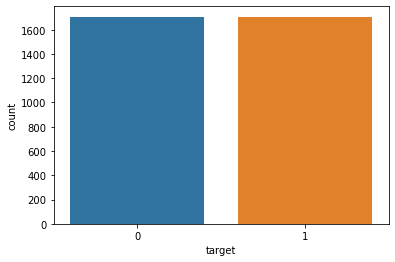

In [31]:
# Balance our class labels and check counts for our count vectorized training data.
rus = RandomUnderSampler(sampling_strategy=1, random_state=42)
cv_train_features_res, y_train_res_cv = rus.fit_resample(cv_train_features, y_train)

sns.countplot(y_train_res_cv)

C:\Users\justi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='target', ylabel='count'>

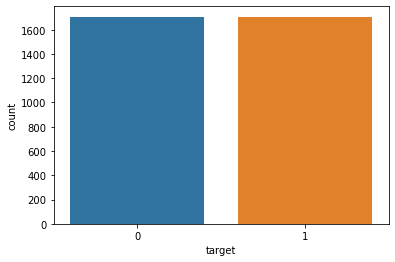

In [32]:
# Balance our class labels and check counts for our tfidf vectorized training data.
rus = RandomUnderSampler(sampling_strategy=1, random_state=42)
tv_train_features_res, y_train_res_tv = rus.fit_resample(tv_train_features, y_train)

sns.countplot(y_train_res_tv)

### Logistic Regression

In [33]:
# Let's try a Logistic Regression model again for our count vectorized data.
# Initiate the model.
LR_b_cv = LogisticRegression(penalty='l2', max_iter=500, C=1, solver='lbfgs', random_state=42)

# Fit LR model with our training data.
LR_b_cv.fit(cv_train_features_res, y_train_res_cv)

# Make predictions using our vectorized test features.
LR_b_bow_predictions = LR_b_cv.predict(cv_test_features)

In [34]:
# Model evaluation.
print(classification_report(y_test, LR_b_bow_predictions))
pd.DataFrame(confusion_matrix(y_test, LR_b_bow_predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.94      0.83      0.88      1867
           1       0.49      0.75      0.59       407

    accuracy                           0.82      2274
   macro avg       0.72      0.79      0.74      2274
weighted avg       0.86      0.82      0.83      2274



,Not Disaster,Disaster
Not Disaster,1552,315
Disaster,102,305


In [35]:
# Let's try a Logistic Regression model again for our tfidf vectorized data.
# Initiate the model.
LR_b_tv = LogisticRegression(penalty='l2', max_iter=500, C=1, solver='lbfgs', random_state=42)

# Fit LR model with our training data.
LR_b_tv.fit(tv_train_features_res, y_train_res_tv)

# Make predictions using our vectorized test features.
LR_b_tfidf_predictions = LR_b_tv.predict(tv_test_features)

In [36]:
# Model evaluation.
print(classification_report(y_test, LR_b_tfidf_predictions))
pd.DataFrame(confusion_matrix(y_test, LR_b_tfidf_predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.94      0.83      0.88      1867
           1       0.49      0.77      0.60       407

    accuracy                           0.82      2274
   macro avg       0.72      0.80      0.74      2274
weighted avg       0.86      0.82      0.83      2274



,Not Disaster,Disaster
Not Disaster,1544,323
Disaster,95,312


Wow! It looks like resampling our data greatly improved recall for the disaster class! While 0.77 isn't too bad of a score let's continue to explore the other models we tried earlier with our new resampled data.

### Random Forest

In [37]:
# Let's now try a Random Forest model using our count vectorized data.
# Initiate the model.
RF_b_cv = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)

# Fit RF model with our training data.
RF_b_cv.fit(cv_train_features_res, y_train_res_cv)

# Make predictions using our vectorized test features.
RF_b_bow_predictions = RF_b_cv.predict(cv_test_features)

In [38]:
# Model evaluation.
print(classification_report(y_test, RF_b_bow_predictions))
pd.DataFrame(confusion_matrix(y_test, RF_b_bow_predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.95      0.83      0.89      1867
           1       0.51      0.78      0.62       407

    accuracy                           0.83      2274
   macro avg       0.73      0.81      0.75      2274
weighted avg       0.87      0.83      0.84      2274



,Not Disaster,Disaster
Not Disaster,1558,309
Disaster,88,319


In [39]:
# Let's now try a Random Forest model using our tfidf vectorized data.
# Initiate the model.
RF_b_tv = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)

# Fit RF model with our training data.
RF_b_tv.fit(tv_train_features_res, y_train_res_tv)

# Make predictions using our vectorized test features.
RF_b_tfidf_predictions = RF_b_tv.predict(tv_test_features)

In [40]:
# Model evaluation.
print(classification_report(y_test, RF_b_tfidf_predictions))
pd.DataFrame(confusion_matrix(y_test, RF_b_tfidf_predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.94      0.84      0.89      1867
           1       0.51      0.75      0.61       407

    accuracy                           0.83      2274
   macro avg       0.72      0.80      0.75      2274
weighted avg       0.86      0.83      0.84      2274



,Not Disaster,Disaster
Not Disaster,1573,294
Disaster,101,306


### KNN

In [41]:
# Let's now try a KNN model using our count vectorized data.
# Initiate the model.
KNN_b_cv = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)

# Fit KNN model with our training data.
KNN_b_cv.fit(cv_train_features_res, y_train_res_cv)

# Make predictions using our vectorized test features.
KNN_b_bow_predictions = KNN_b_cv.predict(cv_test_features)

In [42]:
# Model evaluation.
print(classification_report(y_test, KNN_b_bow_predictions))
pd.DataFrame(confusion_matrix(y_test, KNN_b_bow_predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.86      0.98      0.92      1867
           1       0.75      0.26      0.38       407

    accuracy                           0.85      2274
   macro avg       0.80      0.62      0.65      2274
weighted avg       0.84      0.85      0.82      2274



,Not Disaster,Disaster
Not Disaster,1832,35
Disaster,302,105


In [43]:
# Let's now try a KNN model using our tfidf vectorized data.
# Initiate the model.
KNN_b_tv = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)

# Fit KNN model with our training data.
KNN_b_tv.fit(tv_train_features_res, y_train_res_tv)

# Make predictions using our vectorized test features.
KNN_b_tfidf_predictions = KNN_b_tv.predict(tv_test_features)

In [44]:
# Model evaluation.
print(classification_report(y_test, KNN_b_tfidf_predictions))
pd.DataFrame(confusion_matrix(y_test, KNN_b_tfidf_predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.85      0.99      0.91      1867
           1       0.81      0.20      0.33       407

    accuracy                           0.85      2274
   macro avg       0.83      0.60      0.62      2274
weighted avg       0.84      0.85      0.81      2274



,Not Disaster,Disaster
Not Disaster,1847,20
Disaster,324,83


### SVM

In [45]:
# Let's now try a SVM model using our count vectorized data.
# Initiate the model.
SVM_b_cv = svm.SVC(C=1, gamma=1, random_state=42)

# Fit SVM model with our training data.
SVM_b_cv.fit(cv_train_features_res, y_train_res_cv)

# Make predictions using our vectorized test features.
SVM_b_bow_predictions = SVM_b_cv.predict(cv_test_features)

In [46]:
# Model evaluation.
print(classification_report(y_test, SVM_b_bow_predictions))
pd.DataFrame(confusion_matrix(y_test, SVM_b_bow_predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.86      0.99      0.92      1867
           1       0.91      0.29      0.44       407

    accuracy                           0.87      2274
   macro avg       0.89      0.64      0.68      2274
weighted avg       0.87      0.87      0.84      2274



,Not Disaster,Disaster
Not Disaster,1856,11
Disaster,290,117


In [47]:
# Let's now try a SVM model using our tfidf vectorized data.
# Initiate the model.
SVM_b_tv = svm.SVC(C=1, gamma=1, random_state=42)

# Fit SVM model with our training data.
SVM_b_tv.fit(tv_train_features_res, y_train_res_tv)

# Make predictions using our vectorized test features.
SVM_b_tfidf_predictions = SVM_b_tv.predict(tv_test_features)

In [48]:
# Model evaluation.
print(classification_report(y_test, SVM_b_tfidf_predictions))
pd.DataFrame(confusion_matrix(y_test, SVM_b_tfidf_predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.94      0.85      0.89      1867
           1       0.52      0.76      0.62       407

    accuracy                           0.83      2274
   macro avg       0.73      0.80      0.76      2274
weighted avg       0.87      0.83      0.84      2274



,Not Disaster,Disaster
Not Disaster,1585,282
Disaster,99,308


### Gradient Boosting

In [49]:
# Let's now try a Gradient Boosting model using our count vectorized data.
# Initiate the model.
GB_b_cv = GradientBoostingClassifier(n_estimators=100, max_depth=10, max_features='auto', learning_rate=0.1, random_state=42)

# Fit GB model with our training data.
GB_b_cv.fit(cv_train_features_res, y_train_res_cv)

# Make predictions using our vectorized test features.
GB_b_bow_predictions = GB_b_cv.predict(cv_test_features)

C:\Users\justi\anaconda3\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\justi\anaconda3\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\justi\anaconda3\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\justi\anaconda3\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\justi\a

C:\Users\justi\anaconda3\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\justi\anaconda3\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\justi\anaconda3\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\justi\anaconda3\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\justi\a

C:\Users\justi\anaconda3\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\justi\anaconda3\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\justi\anaconda3\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\justi\anaconda3\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\justi\a

In [50]:
# Model evaluation.
print(classification_report(y_test, GB_b_bow_predictions))
pd.DataFrame(confusion_matrix(y_test, GB_b_bow_predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.93      0.83      0.88      1867
           1       0.48      0.72      0.58       407

    accuracy                           0.81      2274
   macro avg       0.71      0.78      0.73      2274
weighted avg       0.85      0.81      0.82      2274



,Not Disaster,Disaster
Not Disaster,1550,317
Disaster,114,293


In [51]:
# Let's now try a Gradient Boosting model using our tfidf vectorized data.
# Initiate the model.
GB_b_tv = GradientBoostingClassifier(n_estimators=100, max_depth=10, max_features='auto', learning_rate=0.1, random_state=42)

# Fit GB model with our training data.
GB_b_tv.fit(tv_train_features_res, y_train_res_tv)

# Make predictions using our vectorized test features.
GB_b_tfidf_predictions = GB_b_tv.predict(tv_test_features)

C:\Users\justi\anaconda3\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\justi\anaconda3\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\justi\anaconda3\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\justi\anaconda3\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\justi\a

C:\Users\justi\anaconda3\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\justi\anaconda3\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\justi\anaconda3\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\justi\anaconda3\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\justi\a

C:\Users\justi\anaconda3\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\justi\anaconda3\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\justi\anaconda3\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\justi\anaconda3\lib\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\justi\a

In [52]:
# Model evaluation.
print(classification_report(y_test, GB_b_tfidf_predictions))
pd.DataFrame(confusion_matrix(y_test, GB_b_tfidf_predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.93      0.84      0.88      1867
           1       0.49      0.70      0.58       407

    accuracy                           0.82      2274
   macro avg       0.71      0.77      0.73      2274
weighted avg       0.85      0.82      0.83      2274



,Not Disaster,Disaster
Not Disaster,1572,295
Disaster,121,286


## Modeling Recap

The table below contains a summary of all the models we have trained and evaluated on our test set. The extra cell preceding it is for left-binding the table.

In [53]:
%%html
<style>
table {float:left}
</style>

| Imbalanced/Balanced | Vectorizer | Model | Recall |
| :--- | :--- | :--- | :--- |
| Imbalanced | Count | Logistic Regression | <span style='color:Green'>**0.54**</span> |
| Imbalanced | TFIDF | Logistic Regression | 0.36 |
| Imbalanced | Count | Random Forest | 0.49 |
| Imbalanced | TFIDF | Random Forest | 0.49 |
| Imbalanced | Count | KNN | 0.20 |
| Imbalanced | TFIDF | KNN | 0.18 |
| Imbalanced | Count | SVM | 0.19 |
| Imbalanced | TFIDF | SVM | 0.44 |
| Imbalanced | Count | Gradient Boosting | 0.36 |
| Imbalanced | TFIDF | Gradient Boosting | 0.36 |
| Balanced | Count | Logistic Regression | 0.75 |
| Balanced | TFIDF | Logistic Regression | 0.77 |
| Balanced | Count | Random Forest | <span style='color:Green'>**0.78**</span> |
| Balanced | TFIDF | Random Forest | 0.75 |
| Balanced | Count | KNN | 0.26 |
| Balanced | TFIDF | KNN | 0.20 |
| Balanced | Count | SVM | 0.29 |
| Balanced | TFIDF | SVM | 0.76 |
| Balanced | Count | Gradient Boosting | 0.72 |
| Balanced | TFIDF | Gradient Boosting | 0.70 |

We can clearly see that our models using balanced data outperformed their counterpart regularly. Our best model is the random forest one using balanced data and a count vectorizer with a recall of 0.78. This is pretty good score.

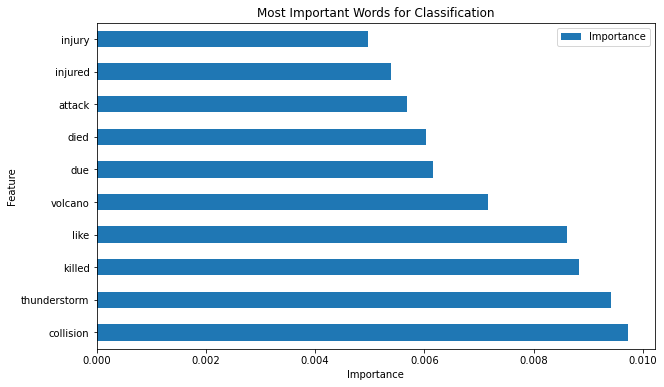

In [54]:
# Take the count vectorizer feature names and merge them with their importance from our best model into a dataframe.
features = cv.get_feature_names_out().tolist()
importance = RF_b_cv.feature_importances_.tolist()

feature_imp = pd.DataFrame(importance, columns = ['Importance'], index = features)
feature_imp = feature_imp.sort_values('Importance', ascending=False)

# Plot the top 10 features with their importance score.
feature_imp[:10].plot(kind = 'barh', figsize=(10, 6))
plt.title('Most Important Words for Classification')
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.show()

The plot above shows which words from our tweets are most useful in helping make accurate predictions for the positive class (since we optimized recall for the disaster class). This doesn't necessarily mean that these words appearing more often makes a tweet more likely to be a disaster, but rather that tweets containing these words help us correctly classify actual disaster tweets. Of course, by using our inution, we can tell for the most part which of these words would help predict disaster tweets.

If we wanted to improve performance even further, our next step would most likely involve trying some deep learning nerual networks. It's worth noting that while this type of model may improve performance, computational time will likely increase.